<a href="https://colab.research.google.com/github/Tanainan/Covid-19Thailand/blob/main/Covid_python_LR%2C_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import packages

In [1]:
!pip install -U tensorflow-addons
# !pip install statsmodels
from numpy import hstack
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import pandas as pd
import numpy as np
from statistics import stdev
from statistics import mean
from matplotlib import pyplot
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)
from matplotlib import pyplot as plt
import datetime as dt
import matplotlib.ticker as ticker
import plotly.graph_objects as go
from statsmodels.graphics.factorplots import interaction_plot
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', None)
import itertools
!pip install -U scikit-learn
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.utils import to_categorical
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

from pathlib import Path
from warnings import simplefilter

import statsmodels.tsa.api as tsa
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


### Cases and Policies

In [3]:
data = read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/jhu/new_cases.csv")

data = pd.DataFrame(data)

# select columns
data = data[["date", "Thailand"]]

# change column name
data = data.rename(columns = {'date':'Date', 'Thailand':'Cases_daily'})

# # change date format
data.Date =  pd.to_datetime(data["Date"])

# replace NaN with 0 for ConfirmedCases and ConfirmedDeaths
data[["Cases_daily"]] = data[["Cases_daily"]].replace(np.nan, 0)

# start from 15/6/2021
data = data[data.loc[data['Date'] == "2021-06-15"].index[0]:]

# # reset index
data_i = data.reset_index(drop = True)


In [4]:
data = read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/jhu/new_deaths.csv")

data = pd.DataFrame(data)

# select columns
data = data[["date", "Thailand"]]

# change column name
data = data.rename(columns = {'date':'Date', 'Thailand':'Deaths_daily'})

# # change date format
data.Date =  pd.to_datetime(data["Date"])

# replace NaN with 0 for ConfirmedCases and ConfirmedDeaths
data[["Deaths_daily"]] = data[["Deaths_daily"]].replace(np.nan, 0)

# start from 15/6/2021
data = data[data.loc[data['Date'] == "2021-06-15"].index[0]:]

# # reset index
data_d = data.reset_index(drop = True)


### Actual Cases

In [5]:
case = read_csv("https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/d98db2da901d5707dc3225ee163903005e7645f3/data/OxCGRT_latest.csv")

case = pd.DataFrame(case)

# select Thailand only
case = case.loc[case['CountryName'] == "Thailand"]

case = case[["Date", "ConfirmedCases", "ConfirmedDeaths"]]

# change date format
case.Date =  pd.to_datetime(case["Date"], format='%Y%m%d')

# reset index
case = case.reset_index(drop = True)

# replace NaN with 0 for ConfirmedCases and ConfirmedDeaths
case[["ConfirmedCases", "ConfirmedDeaths"]] = case[["ConfirmedCases", "ConfirmedDeaths"]].replace(np.nan, 0)

# add daily cases columns
case[["Cases_daily"]] = case['ConfirmedCases'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
case[["Deaths_daily"]] = case['ConfirmedDeaths'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])

# replace NaN with 0 for ConfirmedCases and Deaths_daily
case[["Cases_daily", "Deaths_daily"]] = case[["Cases_daily", "Deaths_daily"]].replace(np.nan, 0)

# start from 15/2/2020
case = case[case.loc[case['Date'] == "2021-06-15"].index[0]:]

# reset index
case = case.reset_index(drop = True)

# remove the last rows with incomplete info
case = case.loc[~(case[["ConfirmedCases"]]==0).all(axis=1)]


In [6]:
window = 3 # for moving average
days_predicted = 14

# moving average
data_i['Cases_daily2'] = data_i.Cases_daily
data_i['Cases_daily'] = data_i.Cases_daily.rolling(window).mean()

data_d['Deaths_daily2'] = data_d.Deaths_daily
data_d['Deaths_daily'] = data_d.Deaths_daily.rolling(window).mean()


# remove NaN
data_i.dropna(subset = ["Cases_daily"], inplace=True)
data_d.dropna(subset = ["Deaths_daily"], inplace=True)

data_i = data_i.reset_index(drop = True)
data_d = data_d.reset_index(drop = True)



# Linear Regression

## Cases

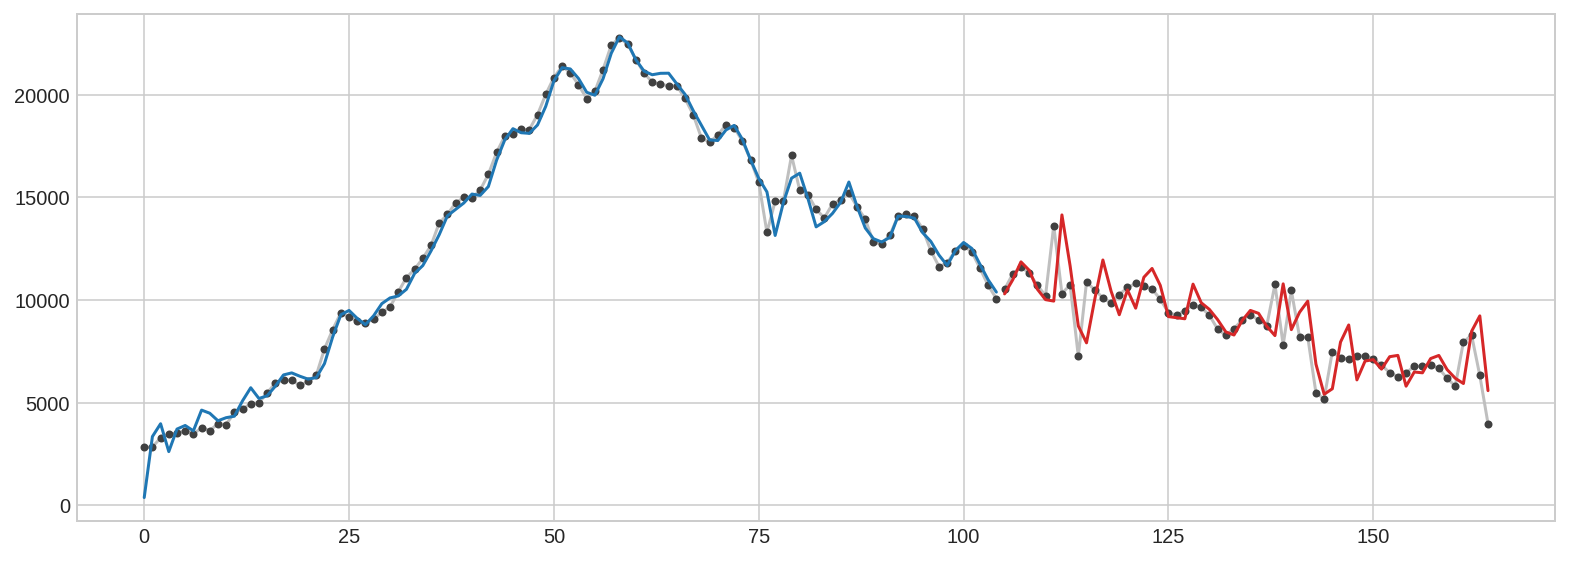

In [7]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X_i = make_lags(data_i.Cases_daily, lags=14)
X_i = X_i.fillna(0.0)

# Create target series and data splits
y_i = data_i.Cases_daily.copy()
X_i_train, X_i_test, y_i_train, y_i_test = train_test_split(X_i, y_i, test_size=60, shuffle=False)

model_i = LinearRegression() 
model_i.fit(X_i_train, y_i_train)
y_pred_i = pd.Series(model_i.predict(X_i_train), index=y_i_train.index)
y_fore_i = pd.Series(model_i.predict(X_i_test), index=y_i_test.index)

ax = y_i_train.plot(**plot_params)
ax = y_i_test.plot(**plot_params)
ax = y_pred_i.plot(ax=ax)
_ = y_fore_i.plot(ax=ax, color='C3')

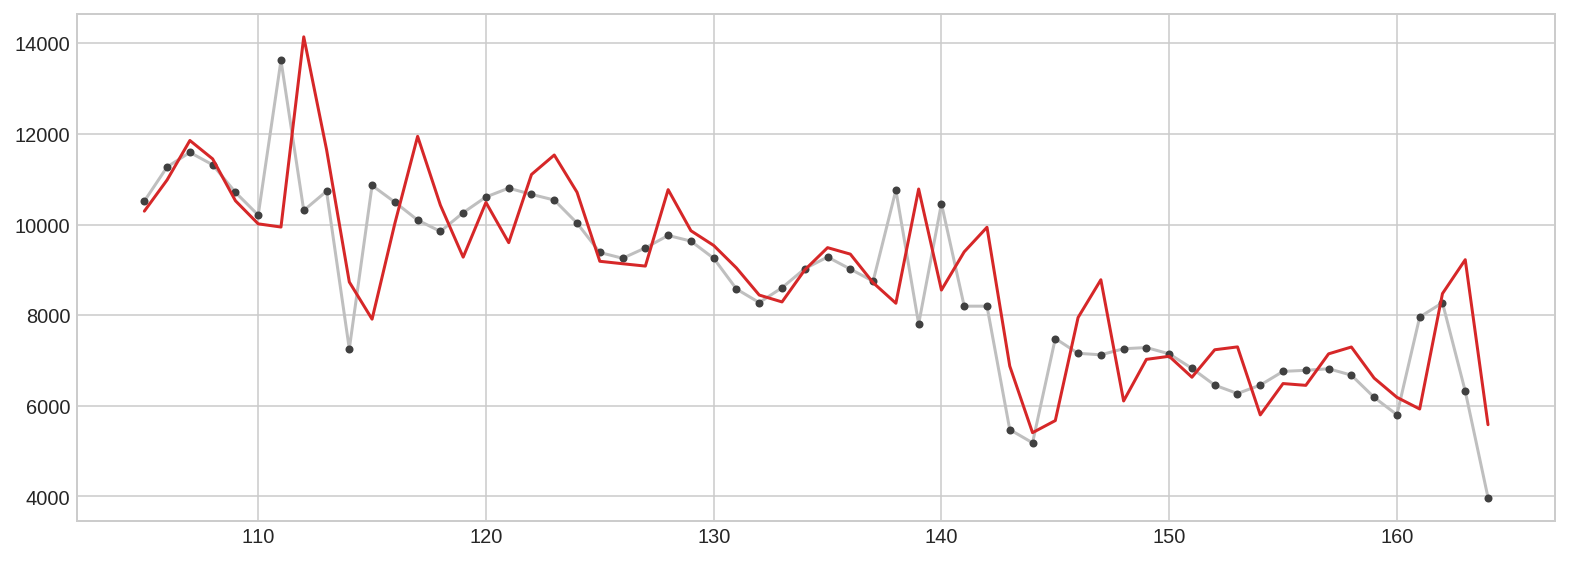

In [8]:
ax = y_i_test.plot(**plot_params)
_ = y_fore_i.plot(ax=ax, color='C3')

In [9]:
model_1_i = LinearRegression()
model_2_i = LinearRegression()
# 1. Train and predict with first model
model_1_i.fit(X_i_train, y_i_train)
y_pred_1_i = model_1_i.predict(X_i_train)

# 2. Train and predict with second model on residuals
model_2_i.fit(X_i_train, y_i_train - y_pred_1_i)
y_pred_2_i = model_2_i.predict(X_i_train)

# 3. Add to get overall predictions
y_pred_i_hybrid = pd.Series(y_pred_1_i + y_pred_2_i)

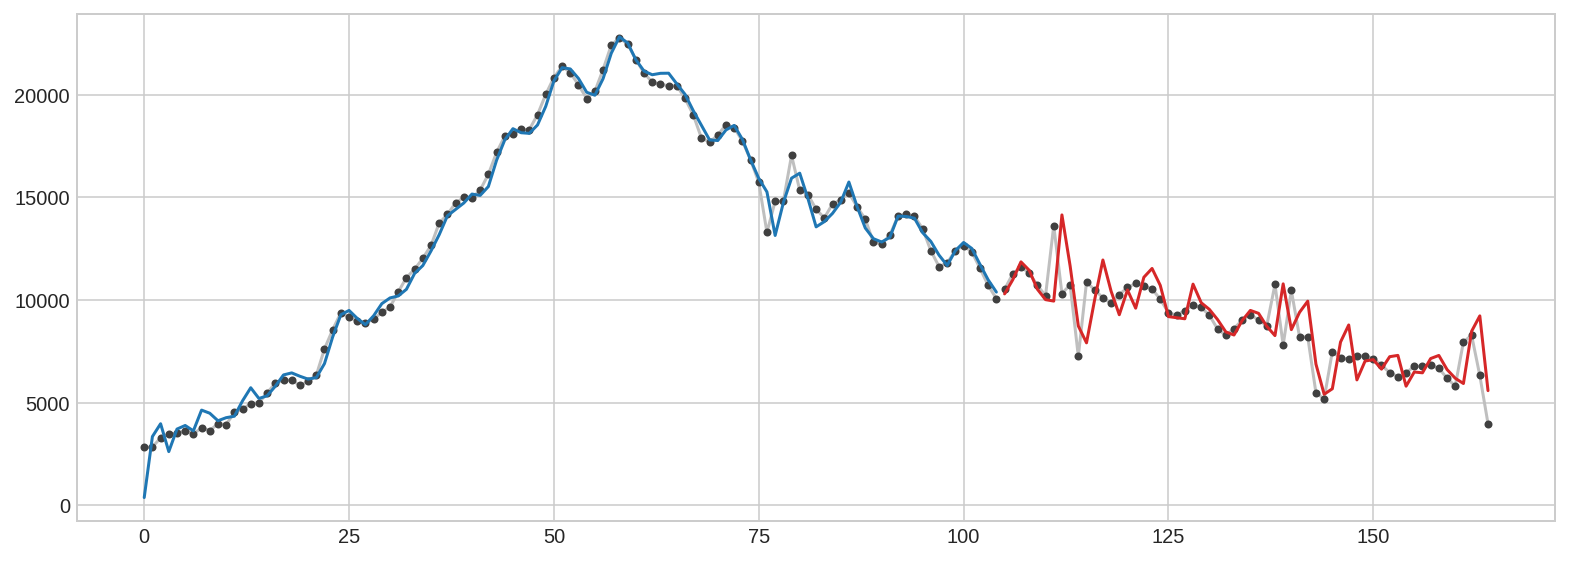

In [10]:
ax = y_i_train.plot(**plot_params)
ax = y_i_test.plot(**plot_params)
ax = y_pred_i_hybrid.plot(ax=ax)
_ = y_fore_i.plot(ax=ax, color='C3')

## Deaths

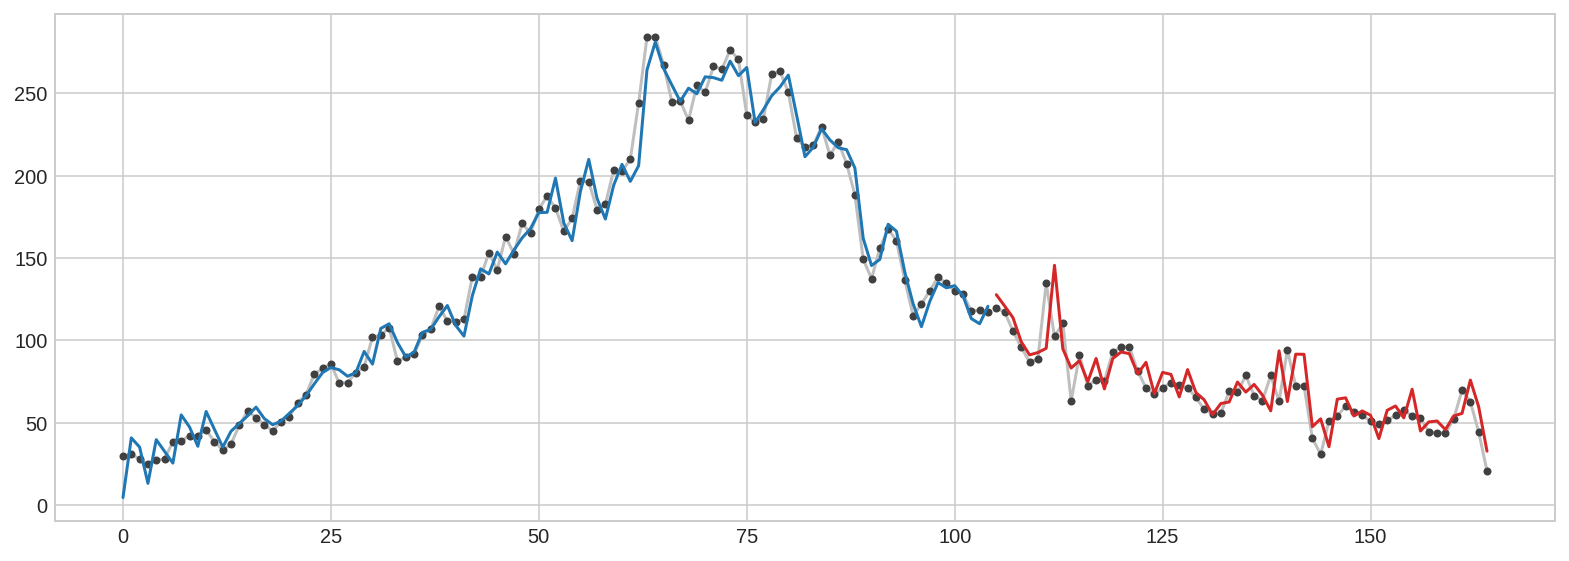

In [11]:
X_d = make_lags(data_d.Deaths_daily, lags=14)
X_d = X_d.fillna(0.0)

# Create target series and data splits
y_d = data_d.Deaths_daily.copy()
X_d_train, X_d_test, y_d_train, y_d_test = train_test_split(X_d, y_d, test_size=60, shuffle=False)

model_d = LinearRegression() 
model_d.fit(X_d_train, y_d_train)
y_pred_d = pd.Series(model_d.predict(X_d_train), index=y_d_train.index)
y_fore_d = pd.Series(model_d.predict(X_d_test), index=y_d_test.index)

ax = y_d_train.plot(**plot_params)
ax = y_d_test.plot(**plot_params)
ax = y_pred_d.plot(ax=ax)
_ = y_fore_d.plot(ax=ax, color='C3')

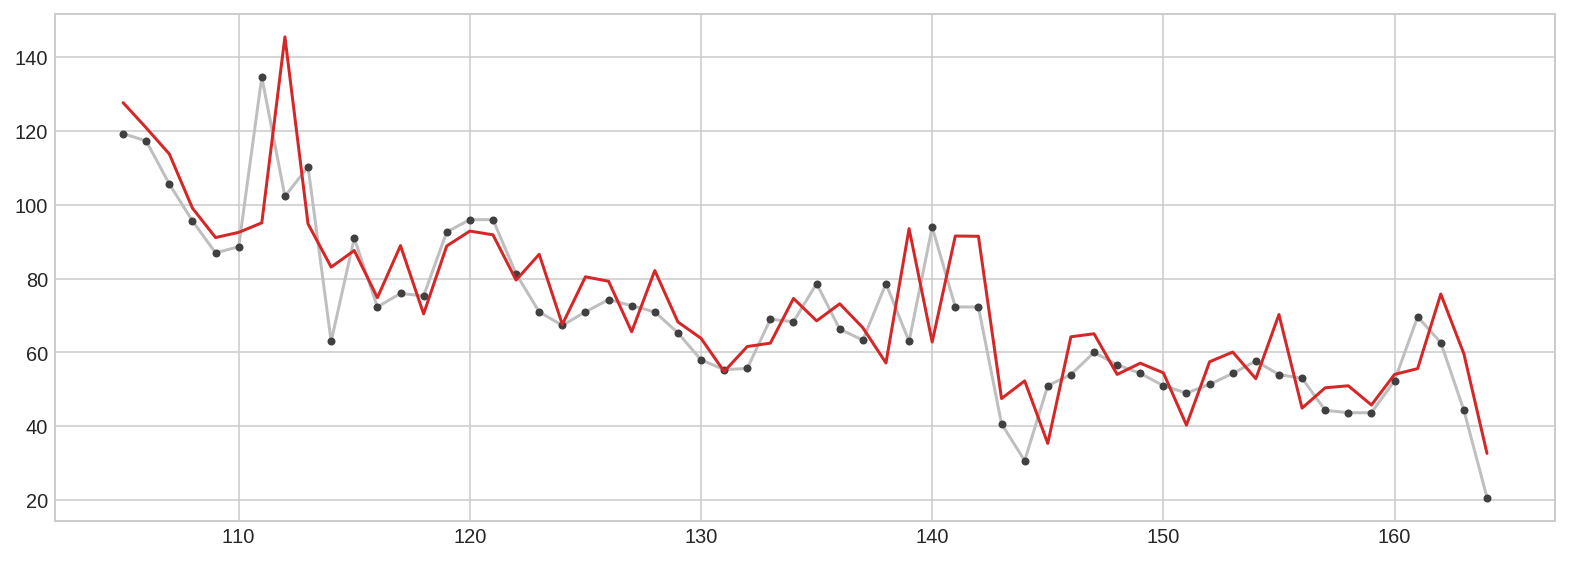

In [12]:
ax = y_d_test.plot(**plot_params)
_ = y_fore_d.plot(ax=ax, color='C3')

In [13]:
model_1_d = LinearRegression()
model_2_d = LinearRegression()
# 1. Train and predict with first model
model_1_d.fit(X_d_train, y_d_train)
y_pred_1_d = model_1_d.predict(X_d_train)

# 2. Train and predict with second model on residuals
model_2_d.fit(X_d_train, y_d_train - y_pred_1_d)
y_pred_2_d = model_2_d.predict(X_d_train)

# 3. Add to get overall predictions
y_pred_d_hybrid = pd.Series(y_pred_1_d + y_pred_2_d)

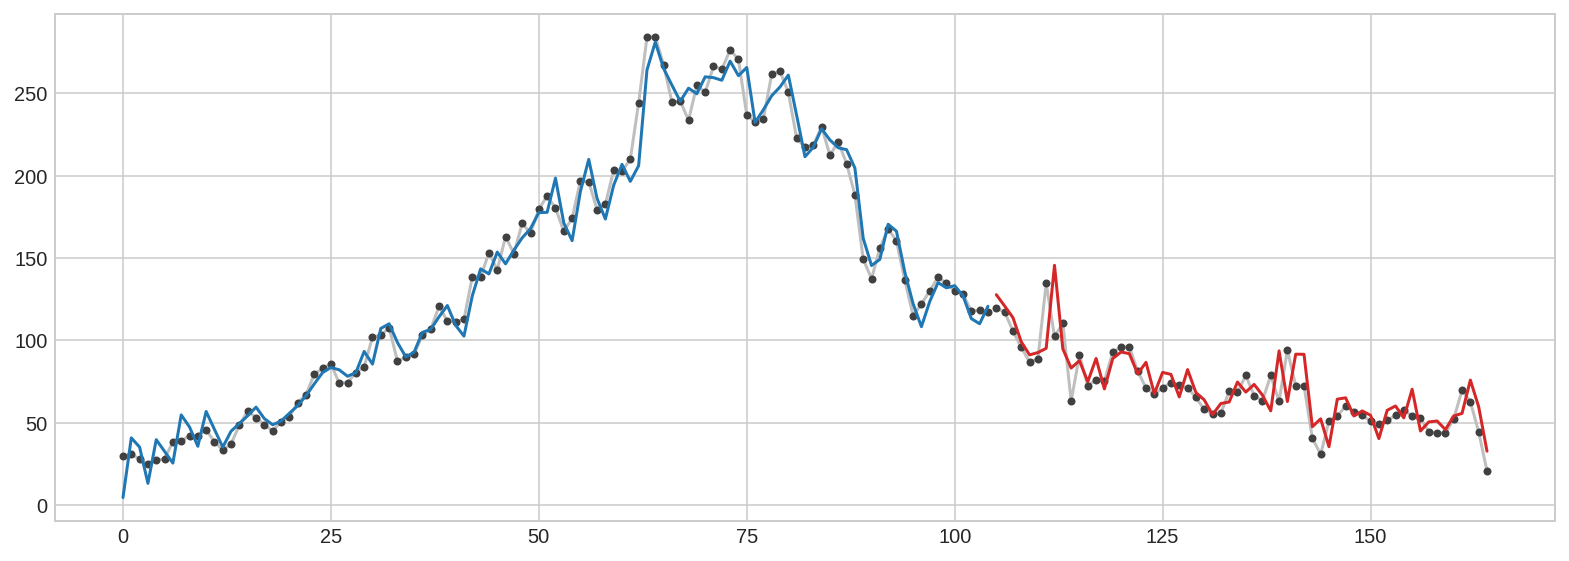

In [14]:
ax = y_d_train.plot(**plot_params)
ax = y_d_test.plot(**plot_params)
ax = y_pred_d_hybrid.plot(ax=ax)
_ = y_fore_d.plot(ax=ax, color='C3')

# XGBoost

In [25]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]
 
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = np.array(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(np.array([testX]))
	return yhat[0]

def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		# print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_percentage_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

lag = 14


## Cases

MAPE: 0.083


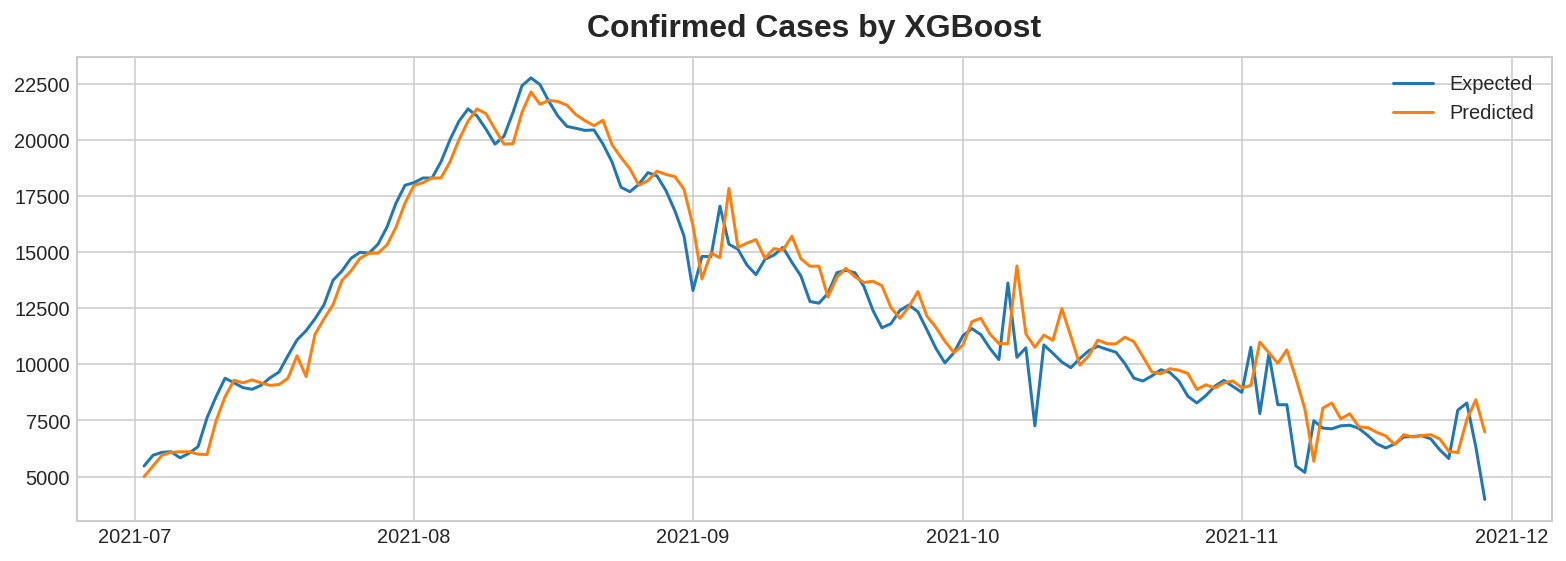

In [33]:
values_i = data_i.Cases_daily.values
values_i = values_i.reshape(values_i.shape[0],1)
# transform the time series data into supervised learning
data_ii = series_to_supervised(values_i, n_in=lag)
# evaluate
mape, y_ii, yhat_ii = walk_forward_validation(data_ii, len(values_i) - lag - 1)
print('MAPE: %.3f' % mape)

infect = pd.concat([pd.Series(y_ii), pd.Series(yhat_ii),
                   data_i.Cases_daily2.iloc[-len(yhat_ii):].reset_index(drop = True), 
                   data_i.Date.iloc[-len(yhat_ii):].reset_index(drop = True)],
                   axis=1)
infect.columns = ['y_ii', 'yhat_ii', 'actual', 'Date']

# plot expected vs preducted
pyplot.title("Confirmed Cases by XGBoost")
pyplot.plot(infect['Date'],infect['y_ii'], label='Expected')
pyplot.plot(infect['Date'],infect['yhat_ii'], label='Predicted')
pyplot.legend()
pyplot.show()


In [28]:
train = series_to_supervised(values, n_in=lag)
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
# fit model
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)
# construct an input for a new preduction
row = values[-lag:].flatten()
# make a one-step prediction
yhat = model.predict(np.array([row]))
print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

Input: [6826.33333333 6456.33333333 6271.33333333 6457.33333333 6760.
 6783.66666667 6818.66666667 6676.33333333 6186.66666667 5803.66666667
 7959.         8274.66666667 6322.33333333 3975.66666667], Predicted: 7291.439


## Deaths

MAPE: 0.132


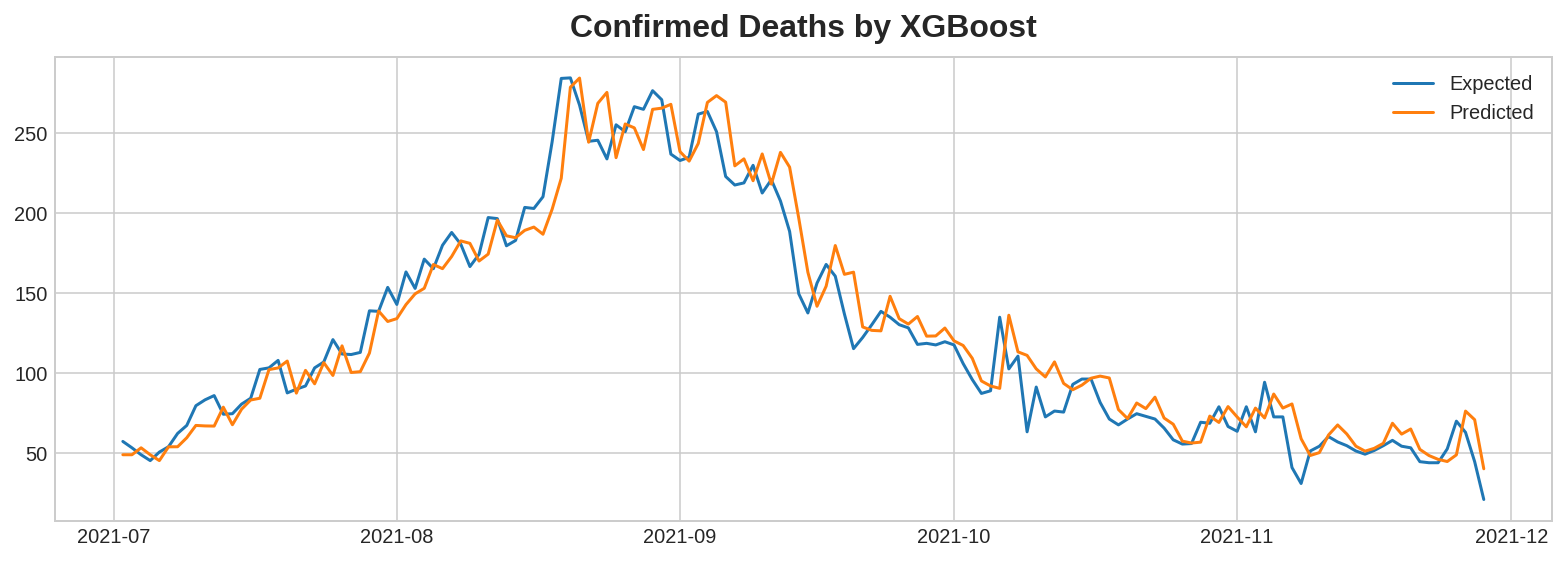

In [34]:
values_d = data_d.Deaths_daily.values
values_d = values_d.reshape(values_d.shape[0],1)
# transform the time series data into supervised learning
data_dd = series_to_supervised(values_d, n_in=lag)
# evaluate
mape, y_dd, yhat_dd = walk_forward_validation(data_dd, len(values_d)-lag-1)
print('MAPE: %.3f' % mape)

death = pd.concat([pd.Series(y_dd), pd.Series(yhat_dd),
                   data_d.Deaths_daily2.iloc[-len(yhat_dd):].reset_index(drop = True), 
                   data_d.Date.iloc[-len(yhat_dd):].reset_index(drop = True)],
                   axis=1)
death.columns = ['y_dd', 'yhat_dd', 'actual', 'Date']

# plot expected vs preducted
pyplot.title("Confirmed Deaths by XGBoost")
pyplot.plot(death['Date'],death['y_dd'], label='Expected')
pyplot.plot(death['Date'],death['yhat_dd'], label='Predicted')
pyplot.legend()
pyplot.show()


In [30]:
train = series_to_supervised(values, n_in=lag)
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
# fit model
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)
# construct an input for a new preduction
row = values[-lag:].flatten()
# make a one-step prediction
yhat = model.predict(np.array([row]))
print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

Input: [6826.33333333 6456.33333333 6271.33333333 6457.33333333 6760.
 6783.66666667 6818.66666667 6676.33333333 6186.66666667 5803.66666667
 7959.         8274.66666667 6322.33333333 3975.66666667], Predicted: 7291.439
